<a href="https://colab.research.google.com/github/sierrarowley/research_fall2020/blob/master/data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import string
import numpy as np

xbound = 10
ybound = 10
point_bound = 1000

def generatedata():
  db = np.empty((xbound, ybound), dtype=object)
  # create random number of points
  for n in range(0, random.randint(1, point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    # at most 10 values per point
    elif len(db[x, y]) < 10:
      db[x, y].append(enc)
  
  return db

The database is classified as either sparse (0) or dense (1). produce_leakage() performs every possible query of the database and saves the results from those queries in a list. The list is returned at the end.

In [3]:
def produce_leakage(db):
  leakage = []
  empty_query_rows = [] # keep track of empty rows(queries) for padding purposes
  query_num = 0 # keep track of row(query) number for empty_query_rows
  dense_flag = 1
  querylen = 0
  # all possible size rectangle queries
  for l in range(1, xbound+1):
    for w in range(1, ybound+1):
      # all possible starting points of the rectangle query
      for x in range(0, xbound):
        # dont perform query if it is out of bounds
        if x+l > xbound:
          break
        for y in range(0, ybound):
          if y+w > ybound:
            break

          # if any point in database is None, then it is not dense
          if db[x, y] == None:
            dense_flag = 0

          curr_query = []
          # loop through current query in the database
          for i in range(x, x+l):
            for j in range(y, y+w):
              # if a point(s) exists at this location in database, add it to the current query
              if db[i, j] != None:
                curr_query.extend(db[i, j])

          # if query is empty, then add [-1] to represent empty         
          if not curr_query:
            leakage.append([-1])
            # keep track of empty queries for padding later
            empty_query_rows.append(query_num)
          # else add query leakage to entire leakage list
          else :
            leakage.append(curr_query)

          # keep track of longest query length for creating input array
          if len(curr_query) > querylen:
            querylen = len(curr_query)
          query_num += 1

  return (leakage, dense_flag, empty_query_rows, querylen)

create_database() calls generatedata() and produce_leakage(), which creates the database and the search query leakages from that database. It then takes the returned list of leakages and transforms it into a 2D numpy array with dimensions (number of queries, length of longest query). All queries with a length shorter than the longest are padded with 0's at the end. Each index of the array represents hashed value of a point in a query. create_database() returns the numpy array, which represents one input to the neural net, and the classification of the database.

In [4]:
def create_database():
  leakage, c, empty_rows, querylen = produce_leakage(generatedata())
  numqueries = len(leakage)
  
  input = np.empty((numqueries, querylen))
  for x in range(0, numqueries):
    q = np.array(leakage[x])
    # empty rows are padded with -1 to distinguish them
    if x in empty_rows:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, -1))
    # all other queries are padded with 0 to be same shape
    else:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, 0))

  # shuffle leakage to make order and location of queries less obvious
  np.random.shuffle(input)
  
  return (input, c)

create_nn_data() creates a specified number of databases that will be used in the training and testing sets for the neural net. It pads each input array (from create_database) so they are all of the same size. It returns an array of inputs of size (number of inputs, number of queries, number of items in query) and an array of the labels.

In [5]:
def create_nn_data(num_inputs):
  data = []
  labels = np.zeros((num_inputs))
  numqueries = 0
  querylen = 0
  # create num_inputs databases for input
  for n in range(0, num_inputs):
    database, label = create_database()
    data.append(database)
    labels[n] = label

    # find largest shape to later pad all databases to be same size
    if database.shape[0] > numqueries:
      numqueries = database.shape[0]
    if database.shape[1] > querylen:
      querylen = database.shape[1]
  
  inputs = np.empty((num_inputs, numqueries, querylen))

  # pad each database
  for i in range(0, len(data)):
    d = data[i]
    d = np.pad(d, ((0, 0), (0, max(querylen - d.shape[1], 0))), 'constant', constant_values=(0, 0))
    inputs[i] = d

  return inputs, labels

Time to make the neural net! I will be using tensorflow with keras

In [5]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# preprocess data
n = 20
inputs, labels = create_nn_data(n)

train_inputs = inputs[0:int(n*.8), :, :, None]
train_labels = labels[0:int(n*.8)]
test_inputs = inputs[int(n*.8):n, :, :, None]
test_labels = labels[int(n*.8):n]

print("train inputs: ", train_inputs.shape, "train labels: ", train_labels.shape)
print("test inputs: ", test_inputs.shape, "test labels: ", test_labels.shape)

#train_inputs = np.reshape(train_inputs, (train_inputs.shape[0], -1))
#test_inputs = np.reshape(test_inputs, (test_inputs.shape[0], -1))


# create model
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, strides=(2, 2), padding='same', activation='relu', kernel_regularizer='L2'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    #keras.layers.Conv2D(64, 5, strides=(2, 2), padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Flatten(),
    #keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    #keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_inputs, train_labels, epochs=4)

test_loss, test_acc = model.evaluate(test_inputs,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

train inputs:  (16, 3025, 865, 1) train labels:  (16,)
test inputs:  (4, 3025, 865, 1) test labels:  (4,)
Epoch 1/4


In [6]:
import matplotlib.pyplot as plt

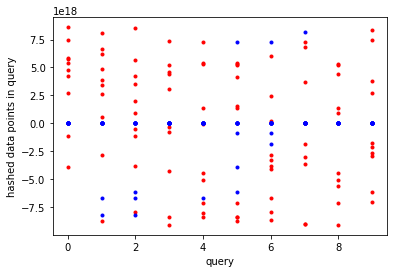

In [21]:
data, labels = create_nn_data(10)
def plot_data():
  #for i in range(0, data.shape[0]):
  plt.plot(data[0, 0:10, 0:10], 'r.')
  plt.plot(data[1, 0:10, 0:10], 'b.')
  plt.xlabel('query')
  plt.ylabel('hashed data points in query')
  plt.show()

plot_data()